C:\TEMP\ipykernel_21252\495278068.py:27: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  if area_col.unary_union.contains(p):
C:\TEMP\ipykernel_21252\495278068.py:75: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_modelo)
c:\Git_SCA\AGE\.venv\Lib\site-packages\spreg\ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


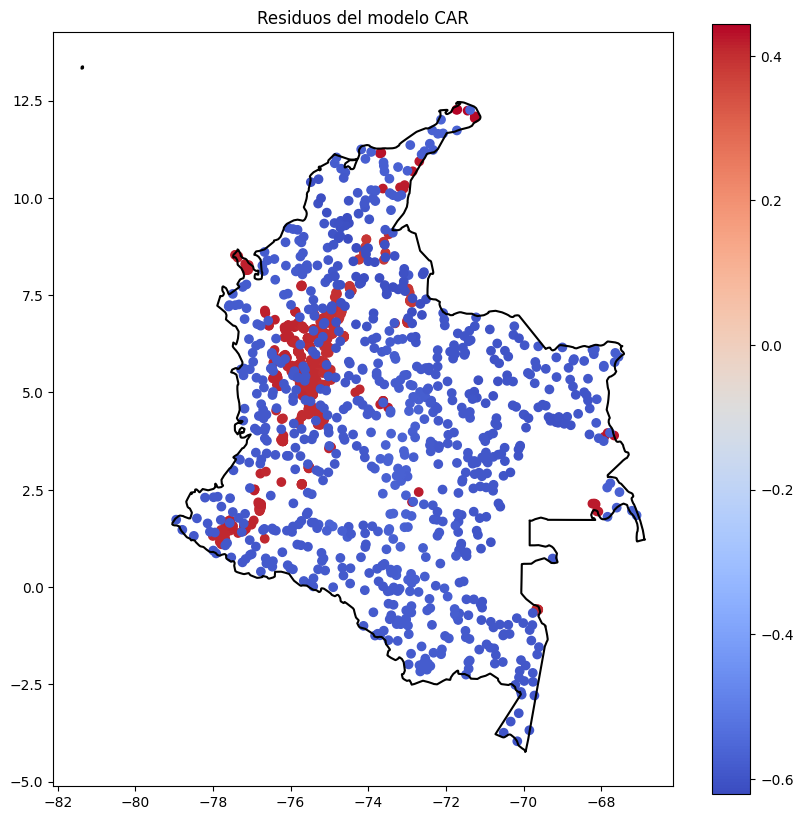

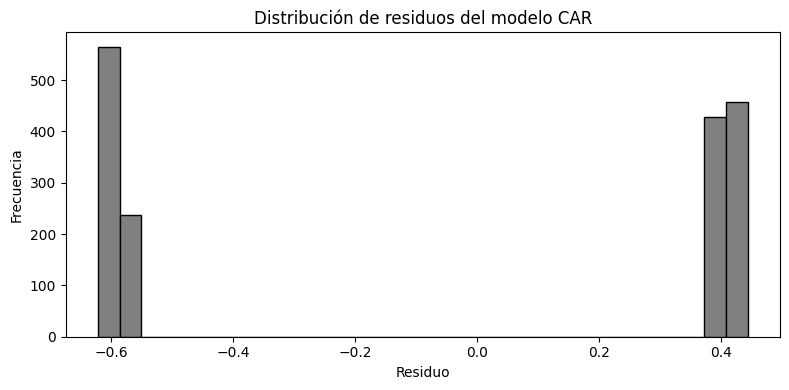

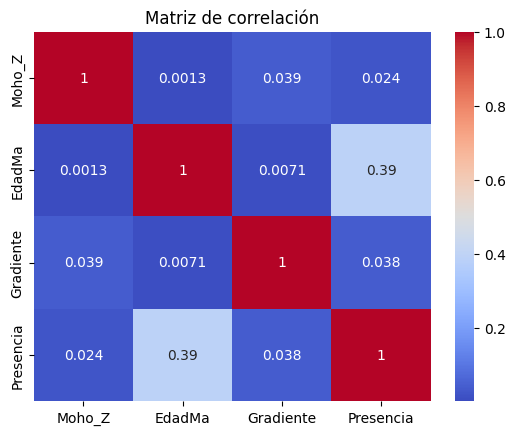

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :       Queen
Dependent Variable  :   Presencia                Number of Observations:        1688
Mean dependent var  :      0.5249                Number of Variables   :           4
S.D. dependent var  :      0.4995                Degrees of Freedom    :        1684
Pseudo R-squared    :      0.0389
Log likelihood      :   -312.6857
Sigma-square ML     :      0.0695                Akaike info criterion :     633.371
S.E of regression   :      0.2636                Schwarz criterion     :     655.097

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.53091    

In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from scipy.interpolate import griddata
from libpysal.weights import Queen
from spreg import ML_Error

# === Cargar shapefiles ===
gdf_depositos = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=4326)
gdf_moho = gpd.read_file("C:/Git_SCA/AGE/Corteza").to_crs(epsg=4326)
gdf_dataciones = gpd.read_file("C:/Git_SCA/AGE/Dataciones").to_crs(epsg=4326)
gdf_gradiente = gpd.read_file("C:/Git_SCA/AGE/Geotermica").to_crs(epsg=4326)
area_col = gpd.read_file("C:/Git_SCA/AGE/Area_col").to_crs(epsg=4326)

# === Crear pseudo-ausencias ===
gdf_depositos["Presencia"] = 1
num_depos = len(gdf_depositos)
rng = np.random.default_rng(42)
pseudo_points = []

while len(pseudo_points) < num_depos:
    x, y = rng.uniform(-80, -65), rng.uniform(-5, 15)
    p = Point(x, y)
    if area_col.unary_union.contains(p):
        pseudo_points.append(p)

gdf_aus = gpd.GeoDataFrame(geometry=pseudo_points, crs="EPSG:4326")
gdf_aus["Presencia"] = 0

# === Unir y extraer coordenadas ===
gdf_total = pd.concat([gdf_depositos, gdf_aus], ignore_index=True)
gdf_total["X"] = gdf_total.geometry.x
gdf_total["Y"] = gdf_total.geometry.y

# === Crear grillas para interpolar ===
grid_x, grid_y = np.mgrid[-80:-65:500j, -5:15:500j]

def interpolar(gdf, columna, grid_x, grid_y, filtro=None):
    gdf = gdf.copy()
    gdf[columna] = pd.to_numeric(gdf[columna].astype(str).str.replace(",", "."), errors="coerce")
    if filtro:
        gdf = gdf.query(filtro)
    coords = np.array([[p.x, p.y] for p in gdf.geometry])
    valores = gdf[columna].values
    grid = griddata(coords, valores, (grid_x, grid_y), method="cubic")
    grid[np.isnan(grid)] = griddata(coords, valores, (grid_x[np.isnan(grid)], grid_y[np.isnan(grid)]), method="nearest")
    return grid

def sample_grid_value(x, y, grid, xmin=-80, xmax=-65, ymin=-5, ymax=15, n=500):
    ix = int((x - xmin) / ((xmax - xmin) / n))
    iy = int((ymax - y) / ((ymax - ymin) / n))
    if 0 <= ix < n and 0 <= iy < n:
        return grid[iy, ix]
    return np.nan

# Interpolar variables
grid_moho = interpolar(gdf_moho, "Z", grid_x, grid_y)
grid_edad = interpolar(gdf_dataciones, "EdadMa", grid_x, grid_y, "EdadMa <= 4000")
grid_grad = interpolar(gdf_gradiente, "GRADIENTE", grid_x, grid_y)

# Asignar valores interpolados
gdf_total["Moho_Z"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_moho), axis=1)
gdf_total["EdadMa"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_edad), axis=1)
gdf_total["Gradiente"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_grad), axis=1)

# Limpiar datos para modelo
gdf_modelo = gdf_total.dropna(subset=["Moho_Z", "EdadMa", "Gradiente"])
gdf_modelo = gdf_modelo[gdf_modelo["EdadMa"] <= 4000].copy()

# === Modelo CAR ===
gdf_modelo = gdf_modelo.to_crs(epsg=3857)
w = Queen.from_dataframe(gdf_modelo)
w.transform = 'r'

X = gdf_modelo[["Moho_Z", "EdadMa", "Gradiente"]].values
y = gdf_modelo["Presencia"].values.reshape(-1, 1)

modelo_car = ML_Error(y, X, w=w, name_y="Presencia", name_x=["Moho_Z", "EdadMa", "Gradiente"], name_w="Queen")

# === Agregar residuos ===
gdf_modelo["residuos"] = modelo_car.u
gdf_modelo = gdf_modelo.to_crs(epsg=4326)
area_col = area_col.to_crs(epsg=4326)

# === Mapa de residuos ===
fig, ax = plt.subplots(figsize=(10, 10))
area_col.boundary.plot(ax=ax, color='black')
gdf_modelo.plot(column="residuos", cmap="coolwarm", ax=ax, legend=True)
plt.title("Residuos del modelo CAR")
plt.show()

# === Histograma ===
plt.figure(figsize=(8, 4))
plt.hist(modelo_car.u, bins=30, color="gray", edgecolor="black")
plt.title("Distribución de residuos del modelo CAR")
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# === Correlaciones ===
df_vars = gdf_modelo[["Moho_Z", "EdadMa", "Gradiente", "Presencia"]]
sns.heatmap(df_vars.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

# === Resumen del modelo ===
print(modelo_car.summary)
